**Import Libraries**

In [77]:
import pyodbc  # For SQL Use
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

**SQL Connection**

In [78]:

# Set up the database connection
conn = pyodbc.connect(
    "Driver={SQL Server};"
    "Server=SHORYA;"
    "Database=dannys_diner;"
    "Trusted_Connection=yes;"
)


Create Cursor and Fetch List Of Tables

In [79]:
cursor = conn.cursor()

# Get a list of all tables in the database
tables_query = "SELECT name FROM sys.tables"
cursor.execute(tables_query)

# Fetch the results
tables = cursor.fetchall()

# Process the results
table_list = [table[0] for table in tables]
print(table_list)




['sales', 'menu', 'members']


Data Exploration

In [80]:
sales= pd.read_sql_query('select * from sales',conn)
sales


,customer_id,order_date,product_id
0,A,2021-01-01,1
1,A,2021-01-01,2
2,A,2021-01-07,2
3,A,2021-01-10,3
4,A,2021-01-11,3
5,A,2021-01-11,3
6,B,2021-01-01,2
7,B,2021-01-02,2
8,B,2021-01-04,1
9,B,2021-01-11,1


In [81]:
menu= pd.read_sql_query('select * from menu',conn)
menu

,product_id,product_name,price
0,1,sushi,10
1,2,curry,15
2,3,ramen,12


In [82]:
members= pd.read_sql_query('select * from members',conn)
members

,customer_id,join_date
0,A,2021-01-07
1,B,2021-01-09


Data Type Of Each Column From Each Table

In [83]:
cursor.execute("SELECT c.name AS ColumnName, t.name AS DataType, ta.name AS TableName \
                FROM sys.columns c \
                INNER JOIN sys.types t ON c.user_type_id = t.user_type_id \
                INNER JOIN sys.tables ta ON c.object_id = ta.object_id")

# Fetch the results
columns = cursor.fetchall()

for column in columns:
    column_name= column.ColumnName
    data_type= column.DataType
    table_name= column.TableName

    print(f"Column Name:{column_name}, Data Type:{data_type}, Table Name:{table_name}")


Column Name:customer_id, Data Type:varchar, Table Name:sales
Column Name:order_date, Data Type:date, Table Name:sales
Column Name:product_id, Data Type:int, Table Name:sales
Column Name:product_id, Data Type:int, Table Name:menu
Column Name:product_name, Data Type:varchar, Table Name:menu
Column Name:price, Data Type:int, Table Name:menu
Column Name:customer_id, Data Type:varchar, Table Name:members
Column Name:join_date, Data Type:date, Table Name:members


**EDA And Visualization**

 
 1. What is the total amount each customer spent at the restaurant?


In [84]:

Total_Amt_Each_Spent=pd.read_sql_query('SELECT s.customer_id, SUM(m.price) as total_amount_each_customer_spent \
                                   FROM sales as s\
                                   JOIN menu as m\
                                   ON s.product_id = m.product_id \
                                   GROUP BY s.customer_id',conn)
Total_Amt_Each_Spent

,customer_id,total_amount_each_customer_spent
0,A,76
1,B,74
2,C,36


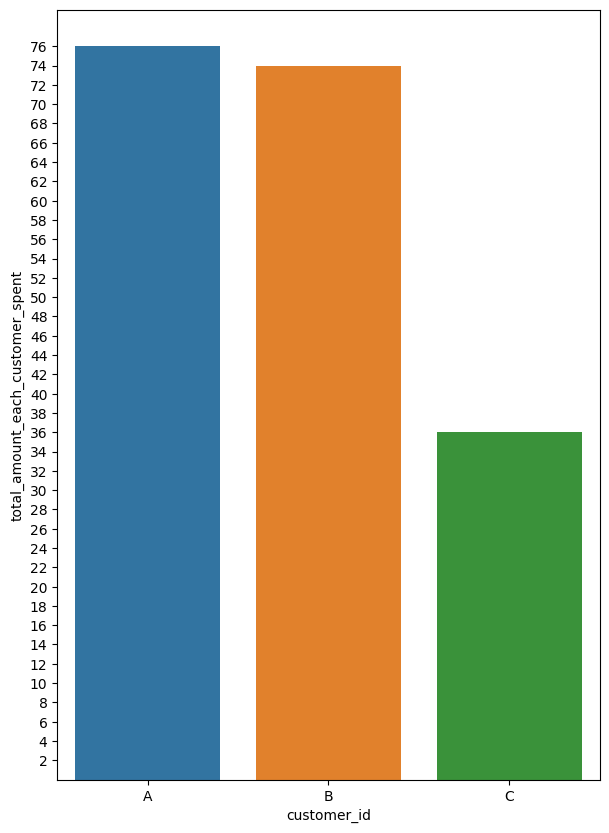

In [85]:
plt.figure(figsize= (7,10))
sns.barplot(data= Total_Amt_Each_Spent,x= Total_Amt_Each_Spent['customer_id'],
            y= 'total_amount_each_customer_spent')

plt.yticks(np.arange(2,78,2))
plt.show()

2. How many days has each customer visited the restaurant?


In [86]:
Visited_Days=pd.read_sql_query('''SELECT customer_id, count(*) as Visited_Days
                  FROM sales
                  GROUP BY customer_id
                  ''',conn)
Visited_Days

,customer_id,Visited_Days
0,A,6
1,B,6
2,C,3


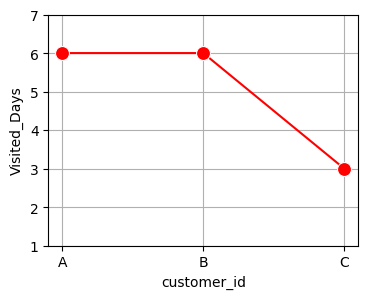

In [87]:
plt.figure(figsize= (4,3))
sns.lineplot(data=Visited_Days,x= Visited_Days['customer_id'],y= Visited_Days['Visited_Days'],
             marker='o', markersize=10, color= 'red')
plt.yticks(np.arange(1,8,1))
plt.grid()
plt.show()

3. What was the first item from the menu purchased by each customer?

In [88]:
First_Purchase= pd.read_sql_query('''SELECT customer_id,order_date,product_name as first_Purchase
FROM(SELECT s.customer_id,m.product_name,s.order_date, ROW_NUMBER() OVER(PARTITION BY s.customer_id ORDER BY s.order_date ASC) as rn
FROM sales s 
JOIN menu m
ON m.product_id=s.product_id) subquery
WHERE rn=1''',conn)

First_Purchase

,customer_id,order_date,first_Purchase
0,A,2021-01-01,sushi
1,B,2021-01-01,curry
2,C,2021-01-01,ramen


In [89]:
df= pd.DataFrame(First_Purchase)
df

,customer_id,order_date,first_Purchase
0,A,2021-01-01,sushi
1,B,2021-01-01,curry
2,C,2021-01-01,ramen


4. What is the most purchased item on the menu and how many times was it purchased by all customers?

In [90]:
Most_Purchased_item= pd.read_sql_query('''SELECT TOP 1 m.product_name,m.product_id,count(*) as Total_Purchase
FROM sales as s
JOIN menu as m
ON m.product_id=s.product_id
GROUP BY m.product_name,m.product_id
ORDER BY Total_Purchase DESC''',conn)

Most_Purchased_item

,product_name,product_id,Total_Purchase
0,ramen,3,8


5. Which item was the most popular for each customer?

In [91]:
Most_Popular_By_Each_Customer= pd.read_sql_query('''SELECT  customer_id,product_name,product_id, Total_Orders
FROM ( SELECT s.customer_id,m.product_name,m.product_id, count (*) as Total_Orders,
ROW_NUMBER() OVER(PARTITION BY s.customer_id ORDER BY count(*) DESC) as rn
FROM sales as s
JOIN menu as m
ON m.product_id=s.product_id
GROUP BY s.customer_id,m.product_name,m.product_id) as subquery
WHERE rn= 1''',conn)
Most_Popular_By_Each_Customer

,customer_id,product_name,product_id,Total_Orders
0,A,ramen,3,3
1,B,curry,2,2
2,C,ramen,3,3


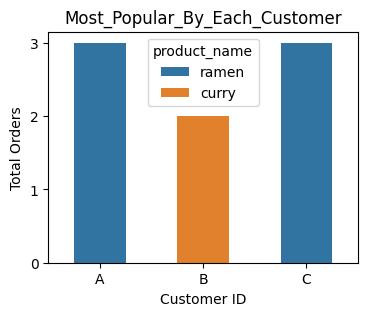

In [92]:
plt.figure(figsize= (4,3))
# Create a bar plot
sns.barplot(x='customer_id', y='Total_Orders', hue='product_name', 
            data=Most_Popular_By_Each_Customer,dodge=False, width= 0.5)

# Add labels and title
plt.xlabel('Customer ID')
plt.ylabel('Total Orders')
plt.yticks(range(0,4))
plt.xticks()
plt.title('Most_Popular_By_Each_Customer')

# Show the plot
plt.show()


6. Which item was purchased first by the customer after they became a member?

In [94]:
First_Item_After_Membership= pd.read_sql_query('''SELECT t.customer_id, first_purchase_date,m.product_name
FROM(SELECT s.customer_id,MIN(order_date) as first_purchase_date
FROM sales as s
JOIN menu as m
ON s.product_id = m.product_id
JOIN members as mem
ON s.customer_id = mem.customer_id
Where s.order_date > mem.join_date
GROUP BY s.customer_id) as t
JOIN sales AS s ON t.customer_id = s.customer_id AND t.first_purchase_date = s.order_date
JOIN menu AS m ON s.product_id = m.product_id;''',conn)

First_Item_After_Membership

,customer_id,first_purchase_date,product_name
0,A,2021-01-10,ramen
1,B,2021-01-11,sushi


7. Which item was purchased just before the customer became a member?

In [97]:
last_purchase_before_membership= pd.read_sql_query('''SELECT customer_id, product_id, last_order, product_name
FROM (
    SELECT s.customer_id, s.product_id, MAX(s.order_date) AS last_order, product_name,
    ROW_NUMBER() OVER (PARTITION BY s.customer_id ORDER BY s.order_date DESC) AS rn
    FROM sales AS s
    JOIN menu AS m ON s.product_id = m.product_id
    JOIN members AS mm ON s.customer_id = mm.customer_id
    WHERE s.order_date < mm.join_date
    GROUP BY s.customer_id, s.product_id, product_name,order_date
) subquery
WHERE rn = 1;''',conn)

last_purchase_before_membership

,customer_id,product_id,last_order,product_name
0,A,1,2021-01-01,sushi
1,B,1,2021-01-04,sushi


8. What is the total items and amount spent for each member before they became a member?

In [98]:
total_item_amtspent_before_membership=pd.read_sql_query('''SELECT s.customer_id,COUNT(s.product_id) as total_items,SUM(m.price) as total_spent
FROM sales s
JOIN menu m
ON s.product_id =m.product_id
JOIN members mm
ON s.customer_id=mm.customer_id
WHERE order_date<join_date
GROUP BY s.customer_id''',conn)

total_item_amtspent_before_membership

,customer_id,total_items,total_spent
0,A,2,25
1,B,3,40


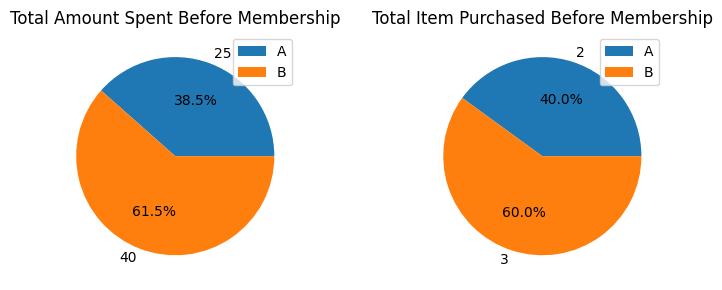

In [145]:
plt.figure(figsize= (8,3))
plt.subplot(1, 2, 1)

plt.pie(data=total_item_amtspent_before_membership, x= 'total_spent',autopct='%1.1f%%',
        labels= total_item_amtspent_before_membership['total_spent'])
plt.title('Total Amount Spent Before Membership')
plt.legend(total_item_amtspent_before_membership['customer_id'],loc=1)

plt.subplot(1, 2, 2) 
plt.pie(data=total_item_amtspent_before_membership, x= 'total_items',autopct='%1.1f%%',
        labels= total_item_amtspent_before_membership['total_items'])
plt.title('Total Item Purchased Before Membership')
plt.legend(total_item_amtspent_before_membership['customer_id'],loc=1)

plt.tight_layout()
plt.show()

9.  If each $1 spent equates to 10 points and sushi has a 2x points multiplier - how many points would each customer have?

In [146]:
Total_points= pd.read_sql('''SELECT s.customer_id,SUM(CASE WHEN m.product_name= 'sushi' Then 2*m.price ELSE m.price END)*10 AS total_points
FROM sales s
JOIN menu m
ON s.product_id= m.product_id
GROUP BY customer_id''',conn)

Total_points
 

,customer_id,total_points
0,A,860
1,B,940
2,C,360


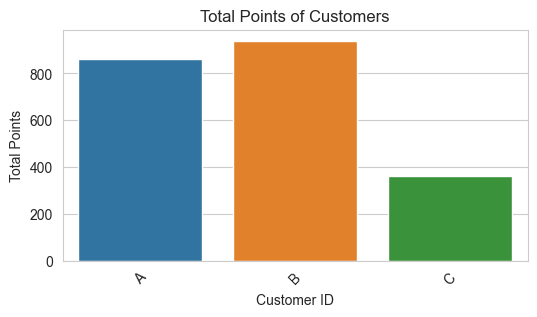

In [154]:
plt.figure(figsize= (6,3))

# Assuming you have a DataFrame named 'customer_points' with columns 'customer_id' and 'total_points'

# Create a bar plot
sns.barplot(x='customer_id', y='total_points', data=Total_points)

# Add labels and title
plt.xlabel('Customer ID')
plt.ylabel('Total Points')
plt.title('Total Points of Customers')

# Add some styling
sns.set_style('whitegrid')  # Set the style of the plot
plt.xticks(rotation=45)  # Rotate the x-axis labels if needed

# Show the plot
plt.show()


10. In the first week after a customer joins the program (including their join date) they earn 2x points on all items, 
not just sushi - how many points do customer A and B have at the end of January?

In [159]:
Total_points=pd.read_sql_query('''SELECT s.customer_id,SUM(CASE WHEN join_date<= DATEADD(DAY,6,join_date) THEN 2*m.price ELSE m.price END)as Total_Points
FROM sales s
JOIN menu m
ON s.product_id =m.product_id
JOIN members mm
ON s.customer_id=mm.customer_id
WHERE YEAR(order_date)= 2021 AND MONTH(order_date)=1
GROUP BY s.customer_id''',conn)

Total_points


,customer_id,Total_Points
0,A,152
1,B,124


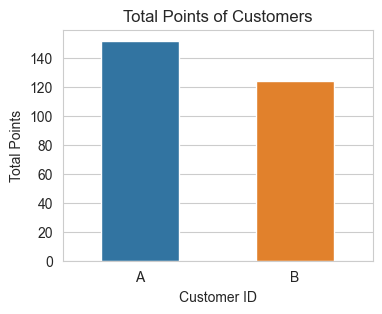

In [167]:
plt.figure(figsize=(4,3))
sns.barplot(data=Total_points, x='customer_id', y='Total_Points',width=0.5)

# Add labels and title
plt.xlabel('Customer ID')
plt.ylabel('Total Points')
plt.title('Total Points of Customers')

# Show the plot
plt.show()